In [10]:
def absolute_magnetization(config): #compute the magnetization
    L = len(config)
    M = abs(sum(config))/L
    return M

In [11]:
def deltaE(J, h, sigma_i, sigma_left, sigma_right):  # if we flip a spin the change in energy depends only in the interaction
                                                     # of the two neighbours spins
    dE = 2 * h * sigma_i + 2 * J * sigma_i * (sigma_left + sigma_right)
    return dE

In [12]:
def metropolis_step(J, h, beta, config):

    chain_size = len(config)
    spin_to_change = np.random.randint(chain_size) #random choice of spin to flip
    sigma_i = config[spin_to_change]

    # periodic condition
    if spin_to_change == chain_size - 1:
        sigma_left = config[(chain_size - 2)]
        sigma_right = config[0]
    elif spin_to_change == 0:
        sigma_left = config[chain_size - 1]
        sigma_right = config[1]
    else:
        sigma_left = config[(spin_to_change - 1)]
        sigma_right = config[(spin_to_change + 1)]

    dE = deltaE(J, h, sigma_i, sigma_left, sigma_right)

    u = np.random.random()
    if dE < 0:
        config[spin_to_change] *= -1
    elif u < np.exp(-beta * dE):
        config[spin_to_change] *= -1  # actually do the flip

    return config

In [13]:
def magnet_average_trajectory(L, beta, J, h, n_steps, n_realizations):

    average_traj = np.zeros(n_steps)
    traj = []
    random_seed = 1
    np.random.seed(random_seed)

    for i in range(n_realizations):
        traj = np.zeros(n_steps)
        config = 2 * np.random.randint(2, size=L) - 1
        for t in range(n_steps):
            config = metropolis_step(J, h, beta, config)
            traj[t] = absolute_magnetization(config)

    average_traj += traj / n_realizations

    return average_traj

In [14]:
def choose_burnIn(J, h, T, chain_size, n_steps):

    fig = plt.figure(figsize=(10, 10))
    trajs = []

    print("Choose burn in from the graph generated")
    trajs.append(magnet_average_trajectory(chain_size, 1/T, J, h, n_steps, 20))

    plt.xlabel('Time steps', fontsize=14)
    plt.ylabel('Average magnetization', fontsize=14)
    fig = plt.plot(trajs[0], label="Temperature={}".format(T))
    plt.legend()
    plt.show()

    return fig

In [15]:
def autocorrelation(L, J, h, T, burn_in_time, max_corr_time, n_realizations):

    print("Choose correlation time from the graph generated")
    # Init the magnetiz product, the first and the second moments
    random_seed = 1
    np.random.seed(random_seed)
    prod = np.zeros(max_corr_time)
    average_at_start = 0
    average_at_next = np.zeros(max_corr_time)
    sec_moment_at_start = 0
    sec_moment_at_next = np.zeros(max_corr_time)

    for i in range(n_realizations):
        # Equilibration
        state = np.random.randint(0, 2, L) * 2 - 1
        for j in range(burn_in_time):
            state = metropolis_step(J, h, 1/T, state)

        # The start value of the magetization is computed after the burn-in period.
        start_magnet = absolute_magnetization(state)
        average_at_start += start_magnet / n_realizations
        sec_moment_at_start += start_magnet * start_magnet / n_realizations

        # Storing the value of all the magnetizations after the burn-in
        traj = np.array([])
        for _ in range(burn_in_time, burn_in_time + max_corr_time):
            state = metropolis_step(J, h, 1/T, state)
            traj = np.append(traj, absolute_magnetization(state))

        # Computing the statistical variables
        prod += start_magnet * traj / n_realizations
        average_at_next += traj / n_realizations
        sec_moment_at_next += traj * traj / n_realizations

    std_start = np.sqrt(sec_moment_at_start - average_at_start ** 2)
    std_next = np.sqrt(sec_moment_at_next - average_at_next ** 2)
    dt_correlation = (prod - average_at_next*average_at_start) / std_start / std_next
    return dt_correlation

In [16]:
def autocorrelation_plot(L,J,h, T, burn_in_time,max_corr_time):

    fig = plt.figure(figsize=(10, 10))
    autocorr_trajs = []
    autocorr_trajs.append(autocorrelation(L, J, h, T, burn_in_time, max_corr_time, 30))

    plt.xlabel('Time steps', fontsize=14)
    plt.ylabel('Temporal autocorrelation', fontsize=14)
    fig = plt.plot(autocorr_trajs[0], label="Temperature={}".format(T))

    plt.legend()
    plt.show()

    return fig

In [17]:
def metropolis_ising(L,J,h,T,n_samples,t_burn_in,t_correlation):

    current_magnetization = []
    current_energy = []
    samples = []
    random_seed = 1
    np.random.seed(random_seed)

    state = 2 * np.random.randint(2, size=L) - 1
    M = sum(state)/L
    for i in range(L):
        H = - state[i] * (J / 2 * state[(i + 1) % L] + state[(i - 1) % L] + h)
    current_magnetization.append(M)
    current_energy.append(H)

    for i in range(t_burn_in): #delete burn-in
        state = metropolis_step(J, h, 1/T, state)
    samples.append(copy(state))

    while len(samples) <= n_samples:
        for i in range(t_correlation): #update after t_correlation = time we have to wait to make the samples indipendent
            state = metropolis_step(J, h, 1/T, state)
        samples.append(copy(state))
    for s in range(len(samples)):
        M = 0
        H = 0
        for i in range(len(samples[s])):
            M += samples[s][i]
            H += - samples[s][i]*(J / 2 * samples[s][(i + 1) % L] + samples[s][(i - 1) % L] + h)
        M = M/len(samples[s])
        current_energy.append(H)
        current_magnetization.append(M)
    return current_energy, current_magnetization


Choose burn in from the graph generated


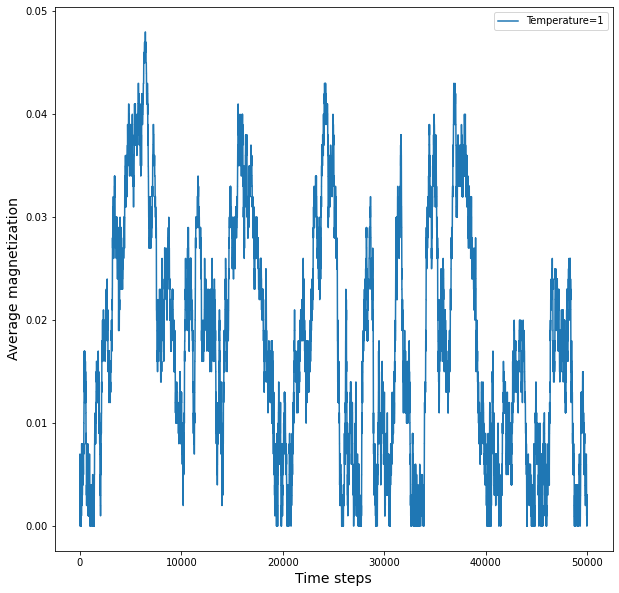

Enter t_burn_in:1000
Choose correlation time from the graph generated


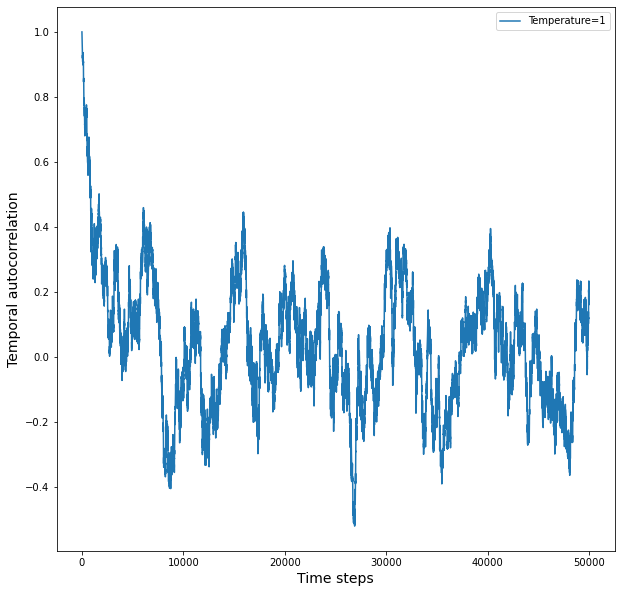

Enter t_correlarion:500
Evaluating energy and magnetization


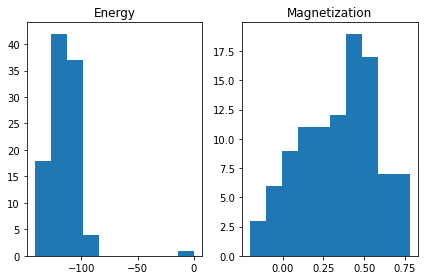

In [18]:
if __name__ == '__main__':
    import numpy as np
    import matplotlib.pyplot as plt
    from copy import copy

    chain_size = 100
    n_steps = 50000
    J = 1
    h = 0.05
    T = 1
    n_samples = 100

    fig_burnIn = choose_burnIn(J, h, T, chain_size, n_steps)
    t_burn_in = int(input("Enter t_burn_in:"))

    fig_correlation = autocorrelation_plot(chain_size, J, h, T, t_burn_in, n_steps)
    t_correlation = int(input("Enter t_correlarion:"))

    print("Evaluating energy and magnetization")

    energy, magnetization = metropolis_ising(chain_size, J, h, T, n_samples, t_burn_in, t_correlation)
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    axs[0].hist(energy)
    axs[0].set_title('Energy')
    axs[1].hist(magnetization)
    axs[1].set_title('Magnetization')
    plt.show()